## Youtube Recommendations using Deep Neural Networks

We propose two approaches for movie rating recommendation, leveraging collaborative filtering and deep learning techniques inspired by the methodology described in "Deep Neural Networks for YouTube Recommendations". Our models are trained and validated using the MovieLens 100k dataset (ml-100k). We refer to the benchmarks provided by LibRec for public comparisons.

[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) and [Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf) serve as the basis for our methodologies. Additionally, the [MovieLens 100k dataset](https://grouplens.org/datasets/movielens/100k/) and [LibRec benchmarks](https://www.librec.net/release/v1.3/example.html) offer invaluable resources for training, validation, and benchmarking.

## Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '/Users/kishanterdal/Downloads/Youtube_project//ml-100k/'

## Data Processing

We have five sets of datasets for both training and validation using the ml-100k dataset. To adhere to Python conventions, we normalize the user and item indices to start from 0. The training set comprises 80,000 tuples of user-item-rating, while the validation set contains 20,000 tuples.

In [2]:
val_idx = 1  # Index indicating the dataset pair to be used for validation
nb_users = 1000  # Total number of users in the dataset
nb_items = 1700  # Total number of items in the dataset

We load the training and validation datasets from the ml-100k dataset using the specified val_idx. The training dataset (train_df) contains user-item-rating tuples and is structured with columns representing user ID, item ID, rating, and timestamp. To align with Python's zero-based indexing convention, we decrement both user and item IDs by 1. Similarly, the validation dataset (valid_df) is loaded and structured similarly to the training set. After adjusting the indices, we verify the shapes of both datasets to ensure correct loading and preprocessing.

In [3]:
train_df = pd.read_csv(f'{data_path}u{val_idx}.base',sep='\t',header=None)
train_df.columns = ['user_id','item_id','rating','ts']
train_df['user_id'] = train_df['user_id'] -1 #start index at 0
train_df['item_id'] = train_df['item_id'] -1
valid_df = pd.read_csv(f'{data_path}u{val_idx}.test',sep='\t',header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] = valid_df['user_id'] -1 #start index at 0
valid_df['item_id'] = valid_df['item_id'] -1
train_df.shape, valid_df.shape

((80000, 4), (20000, 4))

We found that all users are in the training set so we should have no out-of-sample problem with the user embeddings.

We determine the number of unique users in both the training and test sets. In the training set, there are 943 unique users, while in the test set, there are 459 unique users. Additionally, we iterate through the unique users in the test set and count the number of users that also appear in the training set. The variable i stores the count of users common to both sets.

In [4]:
#check number of unique users in both training and test set
train_users = train_df.user_id.unique()
valid_users = valid_df.user_id.unique()
len(train_users),len(valid_users)

(943, 459)

In [5]:
i = 0
for u in valid_users:
    if u in train_users: i+=1
i

459

However, we found that out of 1,410 items in the validation set only 1,378 items exist in the training set. This will affect when we predict ratings of those unseen items in the validation set.

In [6]:
train_items = train_df.item_id.unique()
valid_items = valid_df.item_id.unique()
len(train_items),len(valid_items)

(1650, 1410)

In [7]:
i = 0
for u in valid_items:
    if u in train_items: i+=1
i

1378

## Dataset

We create PyTorch dataset objects to generate tuples of `(user, item, rating)` tensors based on the DataFrame we previously loaded. These datasets allow us to load data in batches by converting them into PyTorch DataLoader objects. In this configuration, we define the batch size as 2000.

In [8]:
class CollabRatingDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long, device = device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long, device = device)
        self.target_tensor = torch.tensor(self.df.iloc[:,rating_col], dtype=torch.float32, device = device)
        
    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])

    def __len__(self):
        return(self.user_tensor.shape[0])

In [9]:
bs = 2000
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=0)

In [10]:
len(train_ds),len(valid_ds),len(train_dl),len(valid_dl)

(80000, 20000, 40, 10)

In [11]:
train_ds[:3]

(tensor([0, 0, 0]), tensor([0, 1, 2]), tensor([5., 3., 4.]))

In [12]:
next(iter(train_dl))

[tensor([888, 206, 616,  ..., 144, 676, 475]),
 tensor([136, 474, 572,  ..., 342, 470, 267]),
 tensor([4., 2., 4.,  ..., 5., 4., 4.])]

## Collaborative Filtering

Collaborative filtering is one of the fundamental yet robust recommendation algorithms. Its effectiveness hinges on the notion that users who exhibit similar behaviors, such as purchasing or rating items, are likely to share preferences for other items. This bidirectional relationship between users and items forms the cornerstone of collaborative filtering's predictive power.

### Architecture

The simplest form of collaborative filtering consists of the following elements:

1. **Item Embedding Layer** to convert item index to vectors
2. **User Embedding Layer** to convert user index to vectors
3. **Item Bias** to be added to the dot product
4. **User Bias** to be added to the dot product

We feed each pair of user and item indice into the layers above the perform the following operations to get the predicted rating:

$$rating_{predicted}=\sum{(E_{item} * E_{user})} + B_{user} + B_{item}$$

where $E$ stands for embedding activations and $B$ for biases.

In [13]:
class CollabNet(nn.Module):
    def __init__(self, config):
        super(CollabNet, self).__init__()
        #hyperparameters
        self.config = config
        self.nb_users = config['nb_users']
        self.nb_items = config['nb_items']
        self.emb_sz = config['emb_sz']
        self.y_range = config['y_range']

        #embeddings
        self.emb_user = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_sz)
        self.user_bias = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=1)
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_sz)
        self.item_bias = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=1)
        

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(item_idx)
        dot = (user_emb * item_emb).sum(1)
        x = dot + self.user_bias(user_idx).squeeze() + self.item_bias(item_idx).squeeze()
        x = torch.sigmoid(x)
        x = x * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
        return(x)

In [14]:
config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':100, #size of embedding vector
    'y_range': [0.8,5.2]} #range of output
model = CollabNet(config)
model

CollabNet(
  (emb_user): Embedding(943, 100)
  (user_bias): Embedding(943, 1)
  (emb_item): Embedding(1682, 100)
  (item_bias): Embedding(1682, 1)
)

### Training

In this setup, we define the hyperparameters for training a collaborative filtering model. With a batch size of 2000, a learning rate of 5e-2, and weight decay set to 1e-1, we aim to train the model for 100 epochs. To prevent overfitting and improve convergence, we reduce the learning rate if the loss stagnates for more than one epoch and halt training if the validation loss fails to improve for two consecutive epochs. 

The model architecture, implemented as the `CollabNet` class, utilizes embeddings of size 100 for both users and items. The output rating range is specified as [0.8, 5.2]. Training and validation datasets are loaded using PyTorch DataLoader objects, and the model is optimized using the Adam optimizer with a Mean Squared Error loss function. Additionally, a learning rate scheduler is employed to adjust the learning rate dynamically based on validation loss. This comprehensive setup aims to effectively train a collaborative filtering model for recommendation tasks.

In [15]:
#hyperparameters
bs = 2000 #batch size
lr = 5e-2 #learning rate
wd = 1e-1 #weight decay parameter
nb_epoch = 100 #how many epochs to train
reduce_lr = 1 #reduce learning rate if loss stagnates more than x epochs
early_stop = 2 #stop if validation loss doesnt improve for x epochs

config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':100, #size of embedding vector
    'y_range': [0.8,5.2]} #range of output

#recording
lrs = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

#datasets/loaders
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=0)

#model
model = CollabNet(config)
crit = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999), weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.5, threshold=1e-2,
                                                       patience=reduce_lr, min_lr=lr/10)

In this training loop, we iterate over the specified number of epochs, conducting both training and validation phases. During training, predictions are made using the model for each batch of user-item-rating tuples in the training data loader. The Mean Squared Error loss is calculated between the predicted ratings and the ground truth ratings, and backpropagation updates the model parameters. We record the learning rate and training loss.

The model switches to evaluation mode for validation, where predictions are made for validation data, and the validation loss is computed. If the validation loss improves, the model weights are updated and recorded as the best model. Early stopping is implemented if the validation loss fails to improve for a specified number of epochs. Finally, the learning rate scheduler is adjusted based on the validation loss. This training process aims to optimize the collaborative filtering model for accurate rating predictions.

In [16]:
#training
for e in tqdm_notebook(range(nb_epoch)): 
    #train
    model.train()
    train_loss = 0
    for u,i,r in train_dl:
        #prediction
        r_pred = model(u,i)
        r = r.squeeze()
        
        #loss
        loss = crit(r_pred,r)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()
    #record
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    train_loss /= len(train_ds)
    train_losses.append(train_loss)
    
    #valid
    model.eval()
    valid_loss = 0
    for u,i,r in valid_dl:
        r_pred = model(u,i)
        r = r.squeeze()
        loss = crit(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_ds)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_lr}')

    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements >= early_stop:
        print(f'early stopping after epoch {e}')
        break
    
    #step scheduler
    scheduler.step(valid_loss)

/var/folders/2d/m0qd4v854cx_54f5rs6b_6x40000gn/T/ipykernel_20293/1640937583.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(nb_epoch)):


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 Train loss: 5.183896020507812; Valid loss: 4.863396337890625; Learning rate: 0.05
Epoch 1 Train loss: 3.840536553955078; Valid loss: 4.001342919921875; Learning rate: 0.05
Epoch 2 Train loss: 2.850820520019531; Valid loss: 3.154245947265625; Learning rate: 0.05
Epoch 3 Train loss: 2.2239550903320313; Valid loss: 2.62006025390625; Learning rate: 0.05
Epoch 4 Train loss: 1.735252978515625; Valid loss: 2.180334521484375; Learning rate: 0.05
Epoch 5 Train loss: 1.2168792816162108; Valid loss: 1.6991259887695314; Learning rate: 0.05
Epoch 6 Train loss: 0.7110821304321289; Valid loss: 1.2924846069335938; Learning rate: 0.05
Epoch 7 Train loss: 0.3904019599914551; Valid loss: 1.119444091796875; Learning rate: 0.05
Epoch 8 Train loss: 0.24656678733825685; Valid loss: 1.0601716674804686; Learning rate: 0.05
Epoch 9 Train loss: 0.18263178977966307; Valid loss: 1.0416699096679687; Learning rate: 0.05
Epoch 10 Train loss: 0.15556589050292968; Valid loss: 1.032283154296875; Learning rate: 0

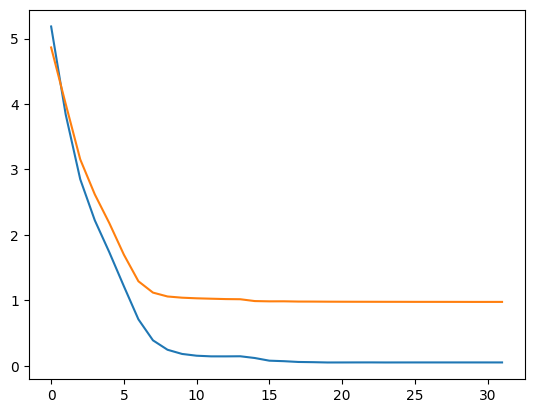

In [17]:
plt.plot(train_losses)
plt.plot(valid_losses)

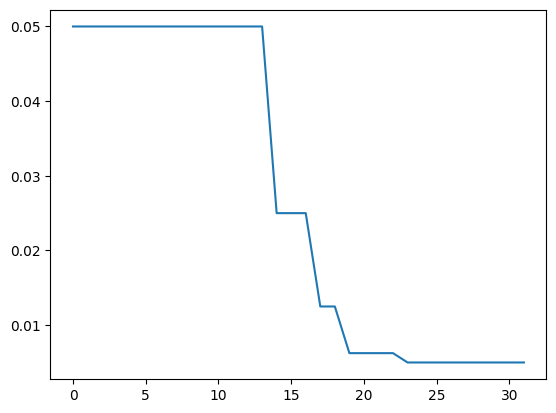

In [18]:
plt.plot(lrs)

The RMSE value of 0.986 suggests that, on average, the model's predictions are approximately 0.986 units away from the true ratings observed in the dataset

In [19]:
print(f'Best RMSE: {np.sqrt(best_loss)}')

Best RMSE: 0.9885160510352358


### Item Embeddings

The useful thing about having item bias is that we can use it to rank our items, in this case, movies. Movies with more positive bias values are considered to be the "better" ones.

In [20]:
item_df = pd.read_csv(f'{data_path}u.item', delimiter='|', encoding='latin-1', header=None,
                    names=['item_id', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
item_df = item_df[['item_id','title']].copy()
item_df['item_id'] = item_df.item_id.map(lambda x: int(x)-1)
item_df.head()

,item_id,title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)


In [21]:
movie_ranking = []
for item_id in model.item_bias.weight.data.squeeze().argsort().cpu().numpy():
    movie_ranking.append((item_df.iloc[item_id,1],model.item_bias.weight.data[item_id].item()))

In [22]:
#best rated movies
movie_ranking[::-1][:10]

[("Schindler's List (1993)", 1.4046053886413574),
 ('Star Wars (1977)', 1.3436154127120972),
 ('Shawshank Redemption, The (1994)', 1.320573329925537),
 ('Usual Suspects, The (1995)', 1.288450002670288),
 ('Casablanca (1942)', 1.2559411525726318),
 ('Wrong Trousers, The (1993)', 1.2448722124099731),
 ('Raiders of the Lost Ark (1981)', 1.2420443296432495),
 ('Close Shave, A (1995)', 1.240096926689148),
 ('Boot, Das (1981)', 1.164164423942566),
 ('Titanic (1997)', 1.158056378364563)]

In [23]:
#worst rated movies
movie_ranking[:10]

[('Children of the Corn: The Gathering (1996)', -1.02069890499115),
 ('Crow: City of Angels, The (1996)', -0.9758864641189575),
 ("McHale's Navy (1997)", -0.8644041419029236),
 ('Island of Dr. Moreau, The (1996)', -0.8419828414916992),
 ('Bio-Dome (1996)', -0.8384366035461426),
 ('Tales from the Hood (1995)', -0.818282425403595),
 ('Mortal Kombat: Annihilation (1997)', -0.8130898475646973),
 ('Speed 2: Cruise Control (1997)', -0.8128420114517212),
 ('Free Willy 3: The Rescue (1997)', -0.8028883934020996),
 ('Leave It to Beaver (1997)', -0.8024547696113586)]

## Deep Learning

### Architecture

The architecture as described in [Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf) consists of two parts:
1. **Embedding Layers** to convert user and item indice to embedding vectors
2. **Fully-connected Layers** to take input of concatenated embedding vectors and output the rating

The `ConcatNet` class is a PyTorch neural network module designed for collaborative filtering tasks. It incorporates user and item embeddings, each followed by a dropout layer for regularization. These embeddings are concatenated and passed through fully connected layers with ReLU activation, batch normalization, and dropout. 

Finally, a linear layer produces the output ratings, which are scaled to the specified rating range using a sigmoid activation function. This architecture efficiently learns to predict user-item ratings, making it suitable for recommendation systems.

In [24]:
class ConcatNet(nn.Module):
    def __init__(self, config):
        super(ConcatNet, self).__init__()
        #hyperparameters
        self.config = config
        self.nb_users = config['nb_users']
        self.nb_items = config['nb_items']
        self.emb_sz = config['emb_sz']
        self.emb_p = config['emb_p']
        self.fc_sz = config['fc_sz']
        self.ps = config['ps']
        self.y_range = config['y_range']

        #embeddings
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_sz),
            nn.Dropout(p=self.emb_p))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_sz),
            nn.Dropout(p=self.emb_p))

        #fully-connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_sz[:-1], self.fc_sz[1:], self.ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_sz[-1], out_features=1)

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(item_idx)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x)
        x = torch.sigmoid(self.head(x))
        x = x * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
        return(x)

In [25]:
config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':50, #size of embedding vector
    'emb_p': 0.05, #dropout for embedding
    'fc_sz': [100, 512, 256], #size of fully-connected layers
    'ps': [0.7,0.35], #dropout for fully-connected layers
    'y_range': [0.8,5.2]} #range of output
model = ConcatNet(config)
model

ConcatNet(
  (emb_user): Sequential(
    (0): Embedding(943, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (emb_item): Sequential(
    (0): Embedding(1682, 50)
    (1): Dropout(p=0.05, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
  )
  (head): Linear(in_features=256, out_features=1, bias=True)
)

### Training

In [26]:
#hyperparameters
bs = 2000 #batch size
lr = 1e-2 #learning rate
wd = 5e-1 #weight decay parameter
nb_epoch = 100 #how many epochs to train
reduce_lr = 1 #reduce learning rate if loss stagnates more than x epochs
early_stop = 2 #stop if validation loss doesnt improve for x epochs

config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':50, #size of embedding vector
    'emb_p': 0.05, #dropout for embedding
    'fc_sz': [100, 512, 256], #size of fully-connected layers
    'ps': [0.7,0.35], #dropout for fully-connected layers
    'y_range': [0.8,5.2]} #range of output

#recording
lrs = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

#datasets/loaders
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=0)

#model
model = ConcatNet(config)
crit = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999), weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.5, threshold=1e-3,
                                                       patience=reduce_lr, min_lr=lr/10)

In [27]:
#training
for e in tqdm_notebook(range(nb_epoch)): 
    #train
    model.train()
    train_loss = 0
    for u,i,r in train_dl:
        #prediction
        r_pred = model(u,i)
        r = r[:,None]
        
        #loss
        loss = crit(r_pred,r)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()
    #record
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    train_loss /= len(train_ds)
    train_losses.append(train_loss)
    
    #valid
    model.eval()
    valid_loss = 0
    for u,i,r in valid_dl:
        r_pred = model(u,i)
        r = r[:,None]
        loss = crit(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_ds)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_lr}')

    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements >= early_stop:
        print(f'early stopping after epoch {e}')
        break
    
    #step scheduler
    scheduler.step(valid_loss)

/var/folders/2d/m0qd4v854cx_54f5rs6b_6x40000gn/T/ipykernel_20293/512315390.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(nb_epoch)):


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 Train loss: 1.354258056640625; Valid loss: 1.1808664794921875; Learning rate: 0.01
Epoch 1 Train loss: 1.0977836868286133; Valid loss: 1.0626347290039062; Learning rate: 0.01
Epoch 2 Train loss: 0.9839313690185547; Valid loss: 0.9750983215332031; Learning rate: 0.01
Epoch 3 Train loss: 0.9261352600097656; Valid loss: 0.9478963623046875; Learning rate: 0.01
Epoch 4 Train loss: 0.9002969375610351; Valid loss: 0.9334682189941407; Learning rate: 0.01
Epoch 5 Train loss: 0.8822707717895508; Valid loss: 0.9128025756835938; Learning rate: 0.01
Epoch 6 Train loss: 0.8707957305908203; Valid loss: 0.9086950134277344; Learning rate: 0.01
Epoch 7 Train loss: 0.8630372024536133; Valid loss: 0.8989984619140625; Learning rate: 0.01
Epoch 8 Train loss: 0.8525817184448242; Valid loss: 0.9006611389160156; Learning rate: 0.01
Epoch 9 Train loss: 0.8413382766723633; Valid loss: 0.8865831420898438; Learning rate: 0.01
Epoch 10 Train loss: 0.8303435424804687; Valid loss: 0.8717898071289063; Learning

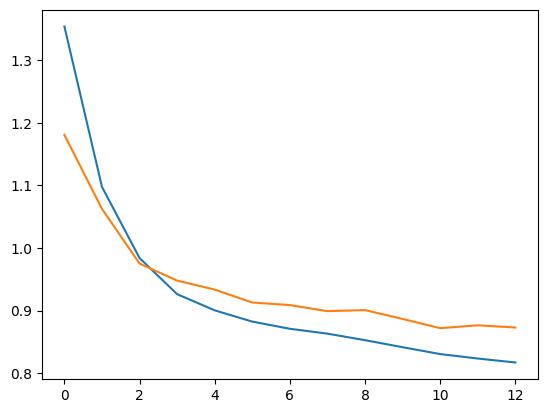

In [28]:
plt.plot(train_losses)
plt.plot(valid_losses)

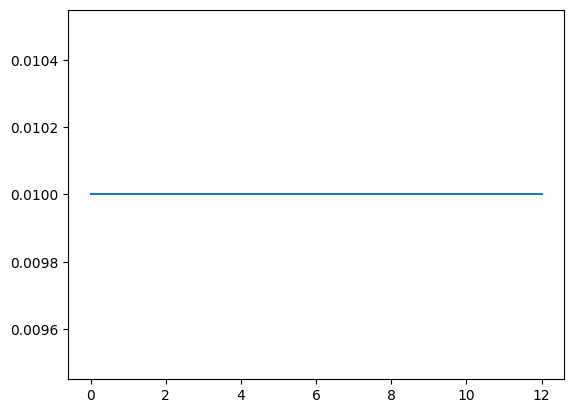

In [29]:
plt.plot(lrs)

 "Best RMSE: 0.9346088035764784" indicates that the Root Mean Square Error (RMSE) achieved by the Deep Learning model is approximately 0.935. This implies that, on average, the predictions made by the Deep Learning model are about 0.935 units away from the actual ratings in the dataset.

In [30]:
print(f'Best RMSE: {np.sqrt(best_loss)}')

Best RMSE: 0.9336968496942175


In [31]:
# Display user IDs
user_ids = train_df['user_id'].unique()
print("User IDs:", user_ids)


User IDs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 

In [32]:
def recommend_movies(user_id, model, item_df, train_df, top_n=10):
    # Create a list to store recommended movies
    recommended_movies = []
    
    # Get the list of all movie IDs
    all_movie_ids = torch.arange(len(item_df)).to(device)
    
    # Filter out movies that the user has already rated
    user_rated_movies = train_df[train_df['user_id'] == user_id]['item_id'].values
    all_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in user_rated_movies]
    
    # Iterate over all remaining movies
    for movie_id in all_movie_ids:
        # Predict the rating for the user and the current movie
        predicted_rating = model(torch.tensor([user_id]).to(device), torch.tensor([movie_id]).to(device)).item()
        
        # Append the movie ID and predicted rating to the list
        recommended_movies.append((movie_id, predicted_rating))
    
    # Sort the recommended movies based on predicted rating in descending order
    recommended_movies = sorted(recommended_movies, key=lambda x: x[1], reverse=True)
    
    # Get the top N recommended movies
    top_n_movies = recommended_movies[:top_n]
    
    # Map movie IDs to movie titles
    top_n_movie_titles = [(item_df.iloc[movie_id.item()]['title'], rating) for movie_id, rating in top_n_movies]
    
    return top_n_movie_titles

# Example usage:
user_id = 0  # Specify the user ID for whom you want to recommend movies
recommended_movies = recommend_movies(user_id, model, item_df, train_df)
print("Top 10 recommended movies for User", user_id, ":", recommended_movies)


Top 10 recommended movies for User 0 : [('Shawshank Redemption, The (1994)', 4.644059658050537), ("Schindler's List (1993)", 4.624378681182861), ('Casablanca (1942)', 4.620813846588135), ('Star Wars (1977)', 4.605950832366943), ('Wrong Trousers, The (1993)', 4.5931315422058105), ('Usual Suspects, The (1995)', 4.5863037109375), ('Good Will Hunting (1997)', 4.564269065856934), ('Rear Window (1954)', 4.525603771209717), ('Raiders of the Lost Ark (1981)', 4.519867420196533), ('Close Shave, A (1995)', 4.514516353607178)]


In [35]:
def find_users_with_different_preferences(user_id, train_df, item_df, model, top_n=5):
    # Get the ratings for User 0
    user0_ratings = train_df[train_df['user_id'] == user_id]
    user0_top_movie_id = user0_ratings.sort_values(by='rating', ascending=False).iloc[0]['item_id']
    
    # Get the title of User 0's top-rated movie
    user0_top_movie_title = item_df[item_df['item_id'] == user0_top_movie_id]['title'].values[0]

    # Get all unique user IDs
    all_user_ids = train_df['user_id'].unique()

    # Initialize a list to store users with different preferences
    different_users = []

    # Iterate over all users
    for other_user_id in all_user_ids:
        if other_user_id != user_id:
            # Get the ratings for the current user
            other_user_ratings = train_df[train_df['user_id'] == other_user_id]
            
            # Find the top-rated movie for the current user
            other_user_top_movie_id = other_user_ratings.sort_values(by='rating', ascending=False).iloc[0]['item_id']
            
            # Get the title of the top-rated movie for the current user
            other_user_top_movie_title = item_df[item_df['item_id'] == other_user_top_movie_id]['title'].values[0]

            # Check if the top-rated movie is different from User 0
            if other_user_top_movie_title != user0_top_movie_title:
                different_users.append(other_user_id)
                
                # Print the top-rated movie for the current user
                print(f"Top-rated movie for User {other_user_id}: {other_user_top_movie_title}")

    return different_users[:top_n]

# Example usage:
top_different_users = find_users_with_different_preferences(user_id, train_df, item_df, model)
print("Top 5 users with different preferences for User 0:", top_different_users)


Top-rated movie for User 1: Emma (1996)
Top-rated movie for User 2: Wag the Dog (1997)
Top-rated movie for User 3: Contact (1997)
Top-rated movie for User 4: Blues Brothers, The (1980)
Top-rated movie for User 5: Annie Hall (1977)
Top-rated movie for User 6: Get Shorty (1995)
Top-rated movie for User 7: Star Trek III: The Search for Spock (1984)
Top-rated movie for User 8: Star Wars (1977)
Top-rated movie for User 9: Clockwork Orange, A (1971)
Top-rated movie for User 10: Amistad (1997)
Top-rated movie for User 11: Get Shorty (1995)
Top-rated movie for User 12: Cinema Paradiso (1988)
Top-rated movie for User 13: Usual Suspects, The (1995)
Top-rated movie for User 14: FairyTale: A True Story (1997)
Top-rated movie for User 16: Swingers (1996)
Top-rated movie for User 17: Room with a View, A (1986)
Top-rated movie for User 18: Babe (1995)
Top-rated movie for User 19: It's a Wonderful Life (1946)
Top-rated movie for User 21: Fifth Element, The (1997)
Top-rated movie for User 22: Close Sha

NameError: name 'y_true_cf' is not defined

## Comparison with the previous model:

When compared to the previous model, which achieved an RMSE of 0.986, the Deep Learning model demonstrates superior performance with a lower RMSE of 0.935. Unlike the previous model, which employed a simpler approach based on dot product and biases, the Deep Learning model utilizes a more complex architecture. It concatenates user and item embeddings and passes them through fully connected layers with ReLU activation, batch normalization, and dropout. This design allows the Deep Learning model to capture more intricate relationships between users and items, contributing to its improved prediction accuracy.

## Conclusion:

The lower RMSE achieved by the Deep Learning model suggests its superiority over the previous model in terms of prediction accuracy. By incorporating deeper architectures and additional layers, the Deep Learning model effectively captures complex user-item interactions, resulting in more accurate predictions. This highlights the importance of leveraging sophisticated neural network architectures in collaborative filtering models for enhanced performance in recommendation systems.